<a href="https://colab.research.google.com/github/NichaRoj/cubems-data-pipeline/blob/master/colab/example_biltsm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
np.random.seed(7)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Bidirectional
from sklearn.metrics import mean_squared_error

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Prepare Dataframe

In [0]:
path = "/content/drive/My Drive/Senior Project- Data Pipeline & Data Analytic/Cham5 Data/Bld_Load_Sum_All_Weather.csv"
df = pd.read_csv(path)

In [0]:
df.head()

,Date,AC_Load(kW),Light_Load(kW),Plug_Load(kW),Total_Load(kW),temp(degF),dew(degF),humidity(%),windspeed(mph),solar(w/m2)
0,2018-07-01 00:00:00,169.256742,191.652042,97.396087,458.304871,77.483333,76.258333,95.916667,0.333333,0.0
1,2018-07-01 01:00:00,170.633793,192.295070,98.402265,461.331127,78.166667,76.933333,95.916667,0.250000,0.0
2,2018-07-01 02:00:00,170.600131,191.796102,97.898014,460.294247,78.308333,76.683333,94.916667,0.833333,0.0
3,2018-07-01 03:00:00,170.043723,190.105935,95.195810,455.345468,78.766667,76.491667,92.833333,0.833333,0.0
4,2018-07-01 04:00:00,169.864992,216.117156,90.437788,476.419937,79.366667,76.166667,90.000000,0.250000,0.0


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11014 entries, 0 to 11013
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            11014 non-null  object 
 1   AC_Load(kW)     11014 non-null  float64
 2   Light_Load(kW)  11014 non-null  float64
 3   Plug_Load(kW)   11014 non-null  float64
 4   Total_Load(kW)  11014 non-null  float64
 5   temp(degF)      11014 non-null  float64
 6   dew(degF)       11014 non-null  float64
 7   humidity(%)     11014 non-null  float64
 8   windspeed(mph)  11014 non-null  float64
 9   solar(w/m2)     11014 non-null  float64
dtypes: float64(9), object(1)
memory usage: 860.6+ KB


In [0]:
#Change to datetime dtype
df['Date']=pd.to_datetime(df['Date'])

#set index to DateTime
df.set_index('Date', inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11014 entries, 2018-07-01 00:00:00 to 2019-12-14 06:00:00
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AC_Load(kW)     11014 non-null  float64
 1   Light_Load(kW)  11014 non-null  float64
 2   Plug_Load(kW)   11014 non-null  float64
 3   Total_Load(kW)  11014 non-null  float64
 4   temp(degF)      11014 non-null  float64
 5   dew(degF)       11014 non-null  float64
 6   humidity(%)     11014 non-null  float64
 7   windspeed(mph)  11014 non-null  float64
 8   solar(w/m2)     11014 non-null  float64
dtypes: float64(9)
memory usage: 860.5 KB


In [0]:
df.describe()

,AC_Load(kW),Light_Load(kW),Plug_Load(kW),Total_Load(kW),temp(degF),dew(degF),humidity(%),windspeed(mph),solar(w/m2)
count,11014.000000,11014.000000,11014.000000,11014.000000,11014.000000,11014.000000,11014.000000,11014.000000,11014.000000
mean,224.522219,171.197881,57.508088,453.228187,84.836450,74.641111,72.705039,1.862352,171.678454
std,146.309364,75.832475,14.906246,170.306587,4.489054,4.460360,12.030189,1.995187,238.766552
min,9.373596,33.854209,29.878878,96.159106,66.833333,47.633333,24.916667,0.000000,0.000000
25%,135.309076,126.041613,47.475971,327.998691,81.808333,73.675000,64.416667,0.083333,0.000000
50%,165.336853,155.688012,54.148788,416.553410,84.441667,75.858333,73.750000,1.250000,9.633333
75%,288.684598,202.411963,64.051024,562.693019,88.033333,77.383333,82.000000,3.000000,326.041667
max,924.720030,572.041501,122.487818,1214.945954,100.800000,82.616667,97.416667,11.250000,972.500000


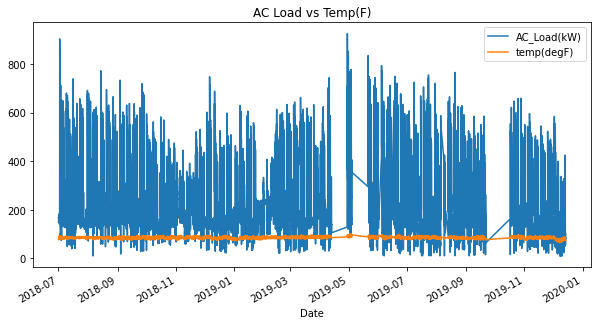

In [0]:
plt.figure(figsize=(10,5))
df['AC_Load(kW)'].plot()
df['temp(degF)'].plot()
plt.title('AC Load vs Temp(F)')
plt.legend(['AC_Load(kW)', 'temp(degF)'], loc='upper right')

#Prepare Dataframe: AC Load

In [0]:
df['ALd-1'] = df['AC_Load(kW)'].shift(1)
df['W']= df.index.dayofweek
df['H']= df.index.hour
df.head()

,AC_Load(kW),Light_Load(kW),Plug_Load(kW),Total_Load(kW),temp(degF),dew(degF),humidity(%),windspeed(mph),solar(w/m2),ALd-1,W,H
Date,,,,,,,,,,,,
2018-07-01 00:00:00,169.256742,191.652042,97.396087,458.304871,77.483333,76.258333,95.916667,0.333333,0.0,NaN,6,0
2018-07-01 01:00:00,170.633793,192.295070,98.402265,461.331127,78.166667,76.933333,95.916667,0.250000,0.0,169.256742,6,1
2018-07-01 02:00:00,170.600131,191.796102,97.898014,460.294247,78.308333,76.683333,94.916667,0.833333,0.0,170.633793,6,2
2018-07-01 03:00:00,170.043723,190.105935,95.195810,455.345468,78.766667,76.491667,92.833333,0.833333,0.0,170.600131,6,3
2018-07-01 04:00:00,169.864992,216.117156,90.437788,476.419937,79.366667,76.166667,90.000000,0.250000,0.0,170.043723,6,4


**Normalize Dataframe**

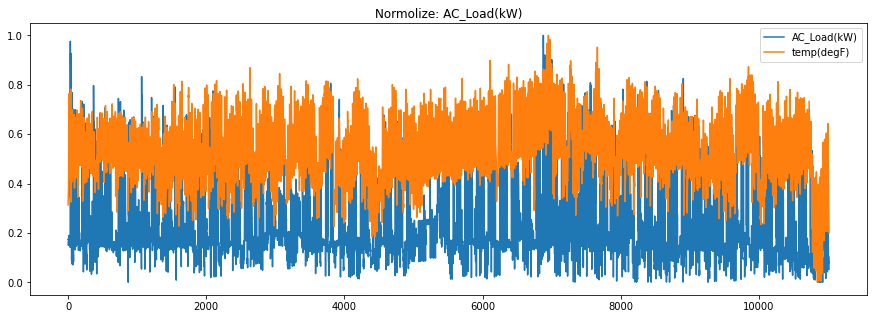

In [0]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
data_ac=scaler.fit_transform(df)

plt.figure(figsize=(15,5))
plt.title('Normolize: AC_Load(kW)')
plt.plot(data_ac[:,0]) #AC_Load(kW)
plt.plot(data_ac[:,4]) #temp(degF)	
plt.legend(['AC_Load(kW)', 'temp(degF)'], loc='upper right')

**Split Train & Test: AC_Load**

In [0]:
n = int(len(data_ac)*0.8)
trainY_ac = data_ac[1:n,0]  #(starting from row1 to remove nan value) 
trainX_ac = data_ac[1:n,4:] 
testY_ac = data_ac[n:len(data_ac),0] #AC_Load(kW)
testX_ac = data_ac[n:len(data_ac),4:] #starting from temp(F) col

print(trainY_ac.shape)
print(trainX_ac.shape)
print('== temp(degF) === dew(degF) === humidity(%) === windspeed(mph) === solar(W/m2 )=== ACLd-1  === W === H === AC_Load(kW) ======')
for i in range(5):
  print(trainX_ac[i], trainY_ac[i])

print(testY_ac.shape)
print(testX_ac.shape)
print('== temp(degF) === dew(degF) === humidity(%) === windspeed(mph) === solar(W/m2 )=== ACLd-1  === W === H === AC_Load(kW) ======')
for i in range(5):
  print(testX_ac[i,:], testY_ac[i])

(8810,)
(8810, 8)
== temp(degF) === dew(degF) === humidity(%) === windspeed(mph) === solar(W/m2 )=== ACLd-1  === W === H === AC_Load(kW) ======
[0.33366045 0.83754169 0.97931034 0.02222222 0.         0.17466955
 1.         0.04347826] 0.17617394952459978
[0.33783121 0.83039543 0.96551724 0.07407407 0.         0.17617395
 1.         0.08695652] 0.1761371744812737
[0.35132483 0.82491663 0.93678161 0.07407407 0.         0.17613717
 1.         0.13043478] 0.17552930895721955
[0.36898921 0.81562649 0.89770115 0.02222222 0.         0.17552931
 1.         0.17391304] 0.17533404807827402
[0.37782139 0.824202   0.89770115 0.01481481 0.         0.17533405
 1.         0.2173913 ] 0.15032950486935484
(2203,)
(2203, 8)
== temp(degF) === dew(degF) === humidity(%) === windspeed(mph) === solar(W/m2 )=== ACLd-1  === W === H === AC_Load(kW) ======
[0.76422964 0.87541687 0.52298851 0.05185185 0.67883462 0.15523241
 0.66666667 0.56521739] 0.5832170690394529
[0.74730128 0.88899476 0.55287356 0.01481481 0.4

**Reshape data before input into BiLTSM**



In [0]:
# reshape input to be [samples, time steps, features]
trainX_ac = trainX_ac.reshape((trainX_ac.shape[0], 1, 8))
testX_ac = testX_ac.reshape((testX_ac.shape[0], 1, 8))
print('trainX_ac.shape=', trainX_ac.shape)
print('testX_ac.shape=', testX_ac.shape)

trainX_ac.shape= (8810, 1, 8)
testX_ac.shape= (2203, 1, 8)


#Create BiLTSM

In [0]:
from tensorflow.keras.optimizers import Adam

In [0]:
opt = Adam(lr=0.005)

model = Sequential()
model.add(Bidirectional(LSTM(6, activation='sigmoid',return_sequences=True, input_shape=(1, 8))))
model.add(Bidirectional(LSTM(6, activation='sigmoid', input_shape=(1, 8))))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer=opt)
history = model.fit(trainX_ac, trainY_ac, validation_split=0.1, epochs=300, batch_size=24, verbose=1)

Epoch 1/300

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

331/331 [==============================] - 2s 5ms/step - loss: 0.0183 - val_loss: 0.0159
Epoch 2/300
331/331 [==============================] - 1s 3ms/step - loss: 0.0109 - val_loss: 0.0144
Epoch 3/300
331/331 [==============================] - 1s 3ms/step - loss: 0.0101 - val_loss: 0.0142
Epoch 4/300
331/331 [==============================] - 1s 3ms/step - loss: 0.0100 - val_loss: 0.0141
Epoch 5/300
331/331 [==============================] - 1s 3ms/step - loss: 0.0099 - val_loss: 0.0142
Epo

In [0]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional multiple                  720       
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  912       
_________________________________________________________________
dense (Dense)                multiple                  13        
Total params: 1,645
Trainable params: 1,645
Non-trainable params: 0
_________________________________________________________________
None


#Predict & Calculate RMSE Epoch 300

In [0]:
#predict #AC_Load(kW)
testPredict = model.predict(testX_ac)

In [0]:
#denormalize the test set
testY_dn = testY_ac*(df['AC_Load(kW)'].max()-df['AC_Load(kW)'].min())+df['AC_Load(kW)'].min()  

#denormalize the prediction
testPredict_dn = testPredict*(df['AC_Load(kW)'].max()-df['AC_Load(kW)'].min())+df['AC_Load(kW)'].min()  

In [0]:
print(testY_dn.shape)
print(testPredict_dn.shape)

(2203,)
(2203, 1)


RMSE= 70.81224345207485
MAPE= 35.13203108580563


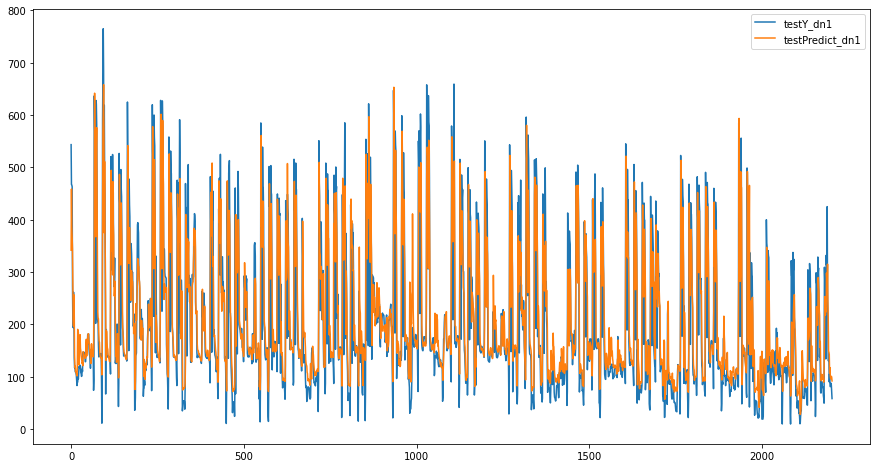

In [0]:
#plot testY vs testPredict
plt.figure(figsize=(15,8))
plt.plot(testY_dn, label='testY_dn1')
plt.plot(testPredict_dn, label='testPredict_dn1')
plt.legend(loc='upper right')

#calculate RMSE and MAPE
RMSE = np.sqrt(np.mean(np.square(testY_dn-testPredict_dn.ravel())))
MAPE = np.mean(np.abs((testY_dn-testPredict_dn.ravel())/testY_dn))*100

print('RMSE=',RMSE)
print('MAPE=',MAPE)

#Check Validation Loss Epoch 300

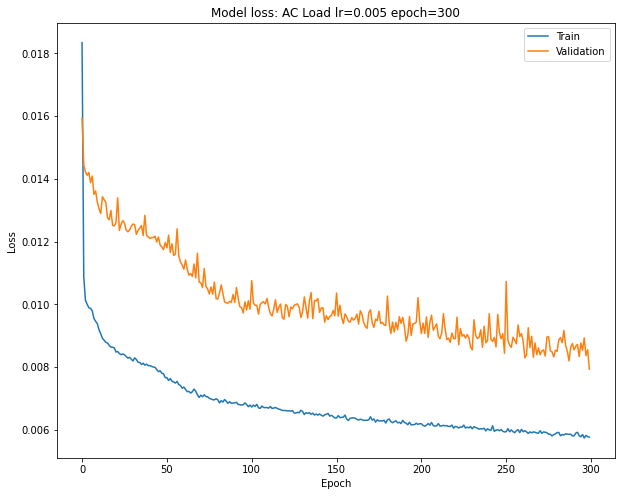

In [0]:
#Check model loss and validation loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss: AC Load lr=0.005 epoch=300')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()